In [2]:
# Imports
#%matplotlib qt
%matplotlib inline 

import matplotlib.pyplot as plt
import mne
import os
import numpy as np
from copy import deepcopy
import math
from scipy.stats import ttest_1samp, ttest_ind, sem, pearsonr
from matplotlib import cm
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from fooof import FOOOF
from fooof import FOOOFGroup

from sklearn.preprocessing import scale

In [3]:
SAVE_FIGS = True

In [4]:
def mask_nan_array(dat):
    return ~np.isnan(dat)

In [5]:
def plot_comp(title, feature, dat1, dat2, save_fig=False, save_name=None):
    """Plot comparison between groups, as a mean value with an errorbar.
    Dat should be 1D vector, with data that can be split up by YOUNG & OLD _INDS.
    """
    fig, ax = plt.subplots(figsize=[2, 4])
    # Split up data
    dat1 = dat1[~np.isnan(dat1)]
    dat2 = dat2[~np.isnan(dat2)]

    means = [np.mean(dat1), np.mean(dat2)]

    sems = [sem(dat1), sem(dat2)]
    plt.errorbar([1, 2], means, yerr=sems, xerr=None, fmt='.',
                 markersize=22, capsize=10, elinewidth=2, capthick=2)
    
    ax.set_xlim([0.5, 2.5])
    plt.xticks([1, 2], ['Trial', 'Rest'])
    
    # Titles & Labels
    ax.set_title(title)
    ax.set_xlabel('State')
    ax.set_ylabel(feature)

    # Set the top and right side frame & ticks off
    #_set_lr_spines(ax, 2)
    #_save_fig(save_fig, save_name)

In [6]:
def save_figure(save_out, name):
    fig_save_path = 'C:\\Users\\abc\\Documents\\Research\\figures'
    if save_out:
        plt.savefig(os.path.join(fig_save_path, name + '.png'))

# To Do's - master version:

### Plotting
- Figure out how to plot topographies with nan values
    - Use MNE masks to select which channels will be plotted
        - Suggestion: add a check for which channels have data. Boolean select these channels & positions to pass into plotting.
- Reorganize notebook for which parts you have to re run

### Quantitative Corrs
- Set it up to measure correlation & plot scatterplot
    - Generally, for any band, any FOOOF feature 
        - First: set band & feature, run to see results (finish the generalization: get a scatter plot & corr)
        - Also: add to plot Medial -> Lateral (abs)
- Collect all R's into corr matrix
- Bonus: plot the corr matrix as a colored plot (red/blue). Hint: plt.imshow(matrix). Extra bonus: add a colorbar. 
        
### Per subject analysis
- Do the same spatial correlations, per subject, collect distributions of r-vals & p-vals
- Plot: boxplots of the R-values, across subjects

### Band to Band Correlations
- Amplitude-amplitude correlations between bands (across channels)
- Plot: corr-matrix

# Loading information

In [7]:
#lOADING CHANNELS FROM txt
save_path = "C:\\Users\\abc\\EEG-MNE\\data"
chan_dat = 'channel_dat.txt'
chan_file = os.path.join(save_path, chan_dat)

In [8]:
subj_dat_num = list(range(3502, 3516))
subj_dat_num2 =list(range(3001, 3015))
all_subj = subj_dat_num + subj_dat_num2

In [9]:
#LOADING CHANNELS from raw data
# This base path will need updating
base_path = 'D:\\abc\\Documents\\Research\\PBA_Data'

# These should stay the same
#subj_dat_fname = '._3001_resampled.set'
subj_dat_fname = '3002_resampled.set'
full_path = os.path.join(base_path, subj_dat_fname)
eeg_dat = mne.io.read_raw_eeglab(full_path, preload=True)

Events like the following will be dropped entirely: ['Rest_End', 'Catch_thresh', 'SPACE released', 'Flash_instr', 'Fix_On'], 26 in total
5738/6872 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
Reading D:\abc\Documents\Research\PBA_Data\3002_resampled.fdt
Reading 0 ... 1896481  =      0.000 ...  3792.962 secs...


<ipython-input-9-a604fe0b632b>:9: RuntimeWarning: Events like the following will be dropped entirely: ['Rest_End', 'Catch_thresh', 'SPACE released', 'Flash_instr', 'Fix_On'], 26 in total
  eeg_dat = mne.io.read_raw_eeglab(full_path, preload=True)
<ipython-input-9-a604fe0b632b>:9: RuntimeWarning: 5738/6872 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
  eeg_dat = mne.io.read_raw_eeglab(full_path, preload=True)


In [10]:
montage = mne.channels.read_montage('standard_1020', eeg_dat.ch_names)

In [11]:
eeg_dat.set_montage(montage)

<RawEEGLAB  |  3002_resampled.fdt, n_channels x n_times : 65 x 1896482 (3793.0 sec), ~940.6 MB, data loaded>

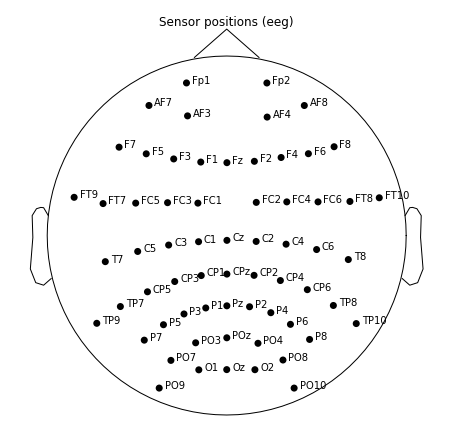

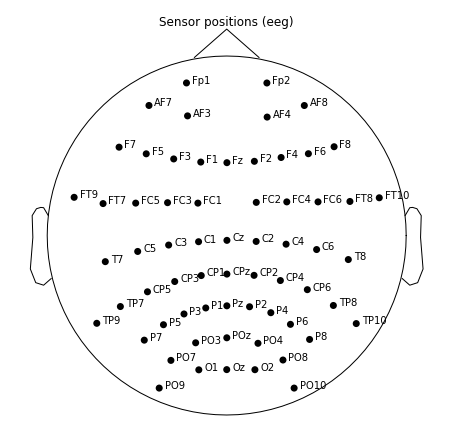

In [12]:
eeg_dat.plot_sensors(show_names=True)

In [13]:
# Extract channel positions from a subjects data object
pos_new = np.asarray([ch['loc'][:3] for ch in eeg_dat.info['chs']])

# Drop stim channel
pos_new = pos_new[:-1, :]

In [14]:
montage.pos = pos_new
pos = montage.get_pos2d()
montage = None

# DATA SET UP

In [15]:
# NEW Data
ret = open('..\\data\\analysis\\rtPB_rest_results.pkl','rb')
rtPB_rest_results = pickle.load(ret)

ret = open('..\\data\\analysis\\rtPB_trial_results.pkl','rb')
rtPB_trial_results = pickle.load(ret)

ret = open('..\\data\\analysis\\PBA_rest_results.pkl','rb')
PBA_rest_results = pickle.load(ret)

ret = open('..\\data\\analysis\\PBA_trial_results.pkl','rb')
PBA_trial_results = pickle.load(ret)

In [16]:
# Slope Data
slope_ret = open('..\\data\\analysis\\rtPB_rest_slope_results.pkl','rb')
rtPB_rest_slope_results = pickle.load(slope_ret)

slope_ret = open('..\\data\\analysis\\rtPB_trial_slope_results.pkl','rb')
rtPB_trial_slope_results = pickle.load(slope_ret)

slope_ret = open('..\\data\\analysis\\PBA_rest_slope_results.pkl','rb')
PBA_rest_slope_results = pickle.load(slope_ret)

slope_ret = open('..\\data\\analysis\\PBA_trial_slope_results.pkl','rb')
PBA_trial_slope_results = pickle.load(slope_ret)

In [20]:
rtPB_rest_slope_results.shape

(14, 2, 64, 2)

# Masking
## This would allow you to choose an entire region to look over

In [21]:
MASKING = True
pos_ch_cluster = ['Oz','O1','O2','POz','PO3','PO4','PO7','PO8','PO9','PO10']
pos_ch_cluster_index = []

for pos_ch in pos_ch_cluster:
    pos_ch_cluster_index.append(eeg_dat.info['ch_names'].index(pos_ch))
    
pos_ch_cluster_index

[29, 28, 30, 61, 60, 62, 59, 63, 27, 31]

# Comparrison across plots
## Settings

In [14]:
# feat_in 0:cfs 1:amps 2:bws 
feat_in = 0
# available bands alpha, beta, theta
curr_band = "alpha"
# dataset
curr_data = "PBA"
# task
curr_task = "trial"


if (curr_data=="PBA" and curr_task=="trial"):
    curr_dataset = deepcopy(PBA_trial_results)
elif (curr_data=="PBA" and curr_task=="rest"):
    curr_dataset = deepcopy(PBA_rest_results)
elif (curr_data=="rtPB" and curr_task=="trial"):
    curr_dataset = deepcopy(rtPB_trial_results)
elif (curr_data=="rtPB" and curr_task=="rest"):
    curr_dataset = deepcopy(rtPB_rest_results)
else:
    print("The dataset you have specified does not exist")

# Validate demeaning

In [ ]:
curr_data_matrix = curr_dataset[curr_band][1,:,29,feat_in]
plt.plot(curr_data_matrix.T, ".");

In [ ]:
for s_ind in range(curr_dataset[curr_band].shape[0]):
    for ch_ind in range(curr_dataset[curr_band].shape[2]):
        for f_ind in range(curr_dataset[curr_band].shape[3]):
            curr_dataset[curr_band][s_ind, :, ch_ind, f_ind] = scale(curr_dataset[curr_band][s_ind, :, ch_ind, f_ind], with_mean=True, axis=0, with_std=False)

In [ ]:


curr_data_matrix = curr_dataset[curr_band][1,:,29,feat_in]
plt.plot(curr_data_matrix.T, ".");

# End Validation

# Validate masking

In [64]:
masked_data = np.take(curr_dataset[curr_band], indices=pos_ch_cluster_index,  axis=2 )

In [ ]:
masked_data.shape

In [ ]:
mean_data = np.nanmean(masked_data, axis = 2)

In [ ]:
mean_data.shape

# End Validation

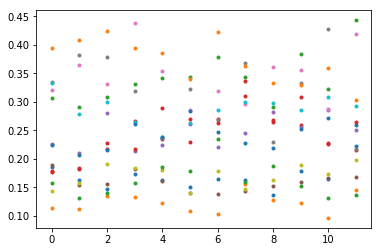

In [35]:
curr_masked_data = np.take(curr_dataset[curr_band], indices=pos_ch_cluster_index,  axis=2 )
curr_mean_data = np.nanmean(curr_masked_data, axis = 2)
curr_data_matrix = curr_mean_data[:,:,feat_in]
plt.plot(curr_data_matrix.T, ".");

save_figure(SAVE_FIGS, 'new_test')

# Demeaning 


In [16]:
for s_ind in range(curr_dataset[curr_band].shape[0]):
    for ch_ind in range(curr_dataset[curr_band].shape[2]):
        for f_ind in range(curr_dataset[curr_band].shape[3]):
            curr_dataset[curr_band][s_ind, :, ch_ind, f_ind] = scale(curr_dataset[curr_band][s_ind, :, ch_ind, f_ind], with_mean=True, axis=0, with_std=False)

C:\Users\abc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:161: RuntimeWarning: Mean of empty slice
  mean_ = np.nanmean(X, axis)
C:\Users\abc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:169: RuntimeWarning: Mean of empty slice
  mean_1 = np.nanmean(Xr, axis=0)
C:\Users\abc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\abc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:161: RuntimeWarning: Mean of empty slice
  mean_ = np.nanmean(X, axis)
C:\Users\abc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:169: RuntimeWarning: Mean of empty slice
  mean_1 = np.nanmean(Xr, axis=0)
C:\Users\abc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:176: UserWarning: Numerical issues were encountere

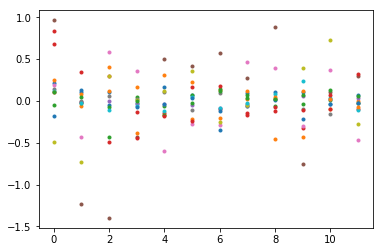

In [17]:
demeaned_curr_masked_data = np.take(curr_dataset[curr_band], indices=pos_ch_cluster_index,  axis=2 )
demeaned_curr_mean_data = np.nanmean(demeaned_curr_masked_data, axis = 2)
demeaned_curr_data_matrix = demeaned_curr_mean_data[:,:,feat_in]
plt.plot(demeaned_curr_data_matrix.T, ".");
save_figure(SAVE_FIGS, 'new_test')

In [ ]:
corrs = []
block_inds = list(range(0, curr_dataset['alpha'].shape[1])
for subj_vec in dat_mat:
    corrs.append(pearsonr(subj_vec, block_inds)[0])

12

In [ ]:
np.nanmean(corr)

In [ ]:
ttest_1samp(corr, 0)

# New process for Across STATE plots
## Settings

In [67]:
# dataset
curr_data = "rtPB"

if (curr_data=="PBA"):
    curr_datasets = [PBA_trial_results, PBA_rest_results]
elif (curr_data=="rtPB"):
    curr_datasets = [rtPB_trial_results, rtPB_rest_results]
else:
    print("The dataset you have specified does not exist")

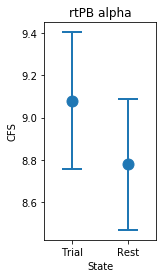

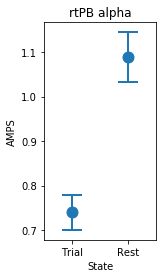

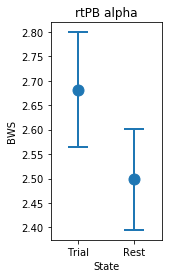

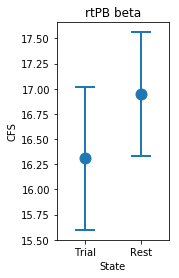

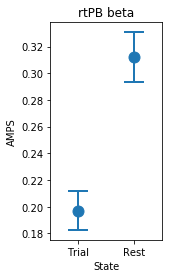

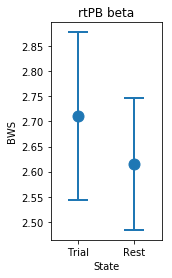

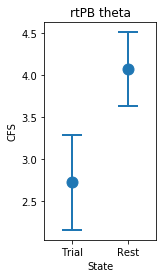

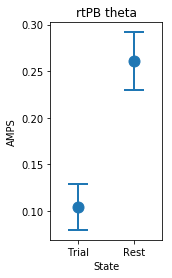

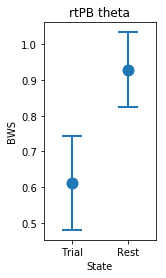

In [68]:
bands = ["alpha", "beta", "theta"]
feats = ["CFS", "AMPS", "BWS"]

for band in bands:
    for feat_in, feat in enumerate(feats):
        outputs = []
        for dataset in curr_datasets:
            masked_data = np.take(dataset[band], indices=pos_ch_cluster_index,  axis=2 )
            masked_feat_in = masked_data[:,:,:,feat_in]
            masked_feat_in_first = masked_feat_in[:,0,:]
            outputs.append(masked_feat_in_first)
        title = curr_data + " " + band
        feature = feat
        plot_comp(title, feature, outputs[0],outputs[1])
        save_figure(SAVE_FIGS, title +"_" + feature + "_across_state")

In [49]:
# feat_in 0:cfs 1:amps 2:bws 
feat_in = 2

outputs = []
for dataset in curr_datasets:
    masked_data = np.take(dataset[curr_band], indices=pos_ch_cluster_index,  axis=2 )
    masked_feat_in = masked_data[:,:,:,feat_in]
    masked_feat_in_first = masked_feat_in[:,0,:]
    outputs.append(masked_feat_in_first)
    

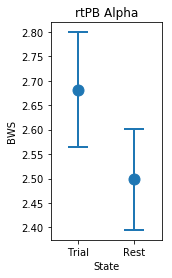

In [50]:
title = "rtPB Alpha"
feature = "BWS"
plot_comp(title, feature, outputs[0],outputs[1])
save_figure(SAVE_FIGS, title + "_" + feature)

In [70]:
ttest_1samp(output[0], np, nan_policy='omit')

TypeError: unsupported operand type(s) for -: 'float' and 'module'

In [71]:
ttest_ind(outputs[0], outputs[1], nan_policy='omit')

Ttest_indResult(statistic=masked_array(data=[-1.9291668721616528, -1.7965984770461094,
                   -2.0464858553238616, -1.4000810588232706,
                   -1.4799605089336991, -1.5772109194620219,
                   -2.0578277733235093, -1.8684983684489997,
                   -2.7326877193291725, -2.6114759464152715],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=1e+20), pvalue=masked_array(data=[0.06469261, 0.08402788, 0.05094378, 0.17330942,
                   0.15090002, 0.12683788, 0.04976263, 0.0734549 ,
                   0.01114439, 0.01477369],
             mask=False,
       fill_value=1e+20))

# TOPOPLOTS
## Settings

In [24]:
across_datasets = []
    
for dataset in curr_datasets:
    feat_set =  curr_datasets[0][curr_band][:,:,:,feat_in]
    bloc_aver_set = np.nanmean(feat_set, axis = 1)
    across_datasets.append(bloc_aver_set)

compl_data = np.vstack((across_datasets[0], across_datasets[1]))
ave_compl_data = np.nanmean(compl_data, axis = 0)

In [86]:
def make_topos(datasets):

    bands = ["alpha", "beta", "theta"]
    feats = ["CFS", "AMPS", "BWS"]

    for band in bands:
        for feat_in, feat in enumerate(feats):
            #print(feat_in)

            topo_dat = np.zeros(shape=[2, 64])

            for ind, dataset in enumerate(datasets):
                topo_dat[ind, :] =  avg_for_topo(dataset, band, feat_in)
                
            #print(topo_dat)

            plot_topo(topo_dat[0, :], title='D1' + band + feat)

            plot_topo(topo_dat[0, :], title='D2' + band + feat)

            plot_topo(np.mean(topo_dat, 0), title='Both' + band + feat)
        

In [84]:
def avg_for_topo(dataset, band, feat_in):
    """
    dataset: 4d array
    band: string
    feat_in: int
    """
    
    feat_set =  dataset[band][:,:,:,feat_in]
    bloc_aver_set = np.nanmean(feat_set, axis = 1)
    bloc_aver_set = np.nanmean(bloc_aver_set, axis = 0)
    
    return bloc_aver_set

In [85]:
avg_for_topo(PBA_trial_results, "alpha", 1)

C:\Users\abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


array([0.51849217, 0.47464417, 0.40173264, 0.35594133, 0.47566219,
       0.37294892, 0.39865667, 0.40600271, 0.45455195, 0.40650651,
       0.40400777, 0.37753977, 0.49668923, 0.54335642, 0.58826574,
       0.33155705, 0.3936039 , 0.58887573, 0.67056138, 0.71744795,
       0.60613931, 0.45415892, 0.6317218 , 0.77072609, 0.82421621,
       0.83443651, 0.67460601, 0.48997358, 0.65072633, 0.62825688,
       0.64622941, 0.50169908, 0.409006  , 0.43460272, 0.43720534,
       0.39147981, 0.37407691, 0.43139996, 0.44196046, 0.36383989,
       0.43028692, 0.39862045, 0.40739578, 0.42185195, 0.41111338,
       0.4270189 , 0.47036461, 0.48422961, 0.55693817, 0.43644405,
       0.45234722, 0.63986678, 0.68892699, 0.7301127 , 0.4624233 ,
       0.72629605, 0.76804049, 0.83875967, 0.77881874, 0.65817025,
       0.85089929, 0.88650947, 0.85950777, 0.71695235])

In [88]:
def plot_topo(data, title):
    """
    data: 1d array, len number of channels
    title: string
    """
    
    inds = np.where(np.isnan(data))
    data[inds] = np.nanmean(data)

    mne.viz.plot_topomap(data, eeg_dat.info, cmap=cm.viridis, contours=0)
    plt.gca()
    save_figure(SAVE_FIGS, title)

C:\Users\abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


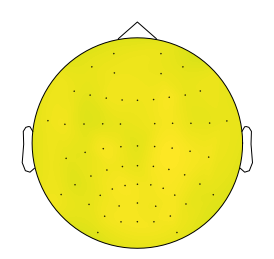

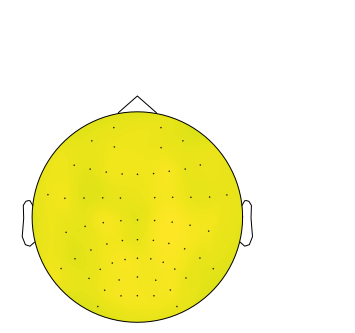

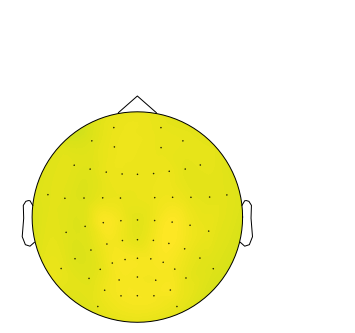

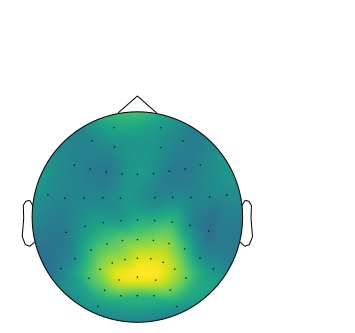

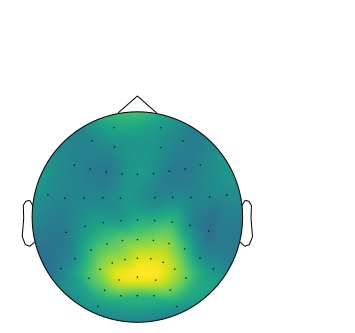

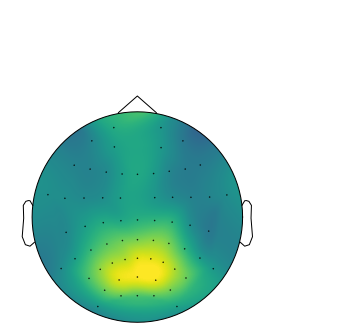

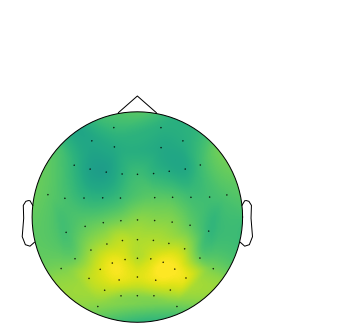

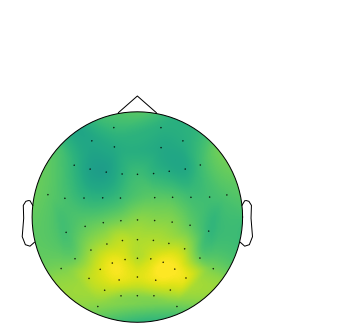

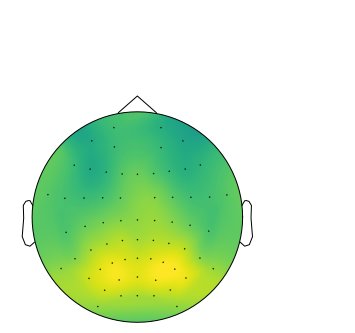

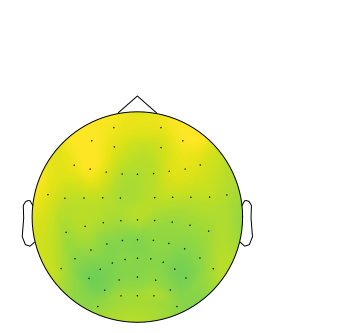

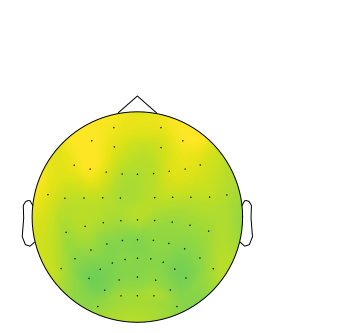

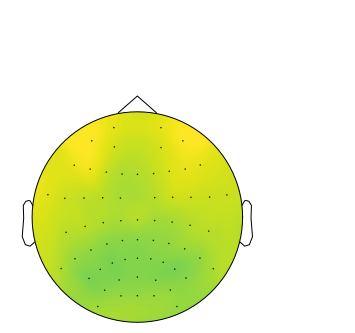

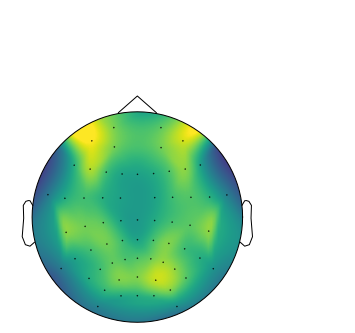

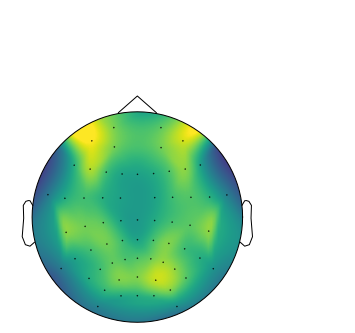

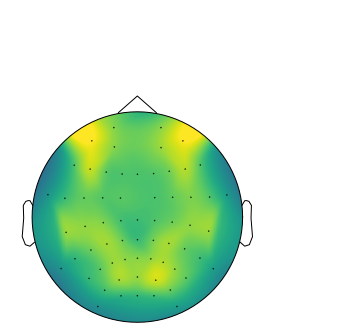

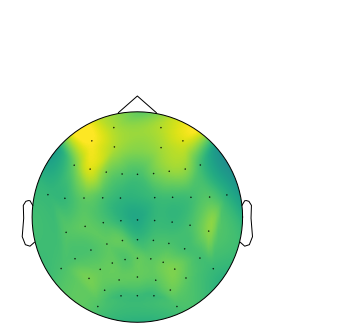

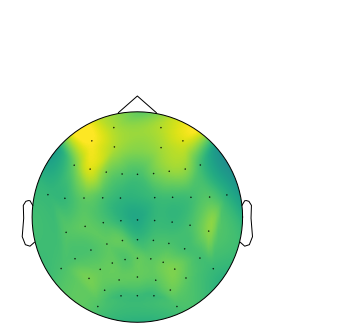

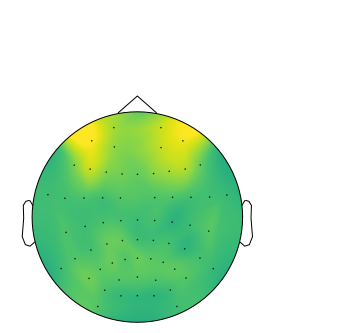

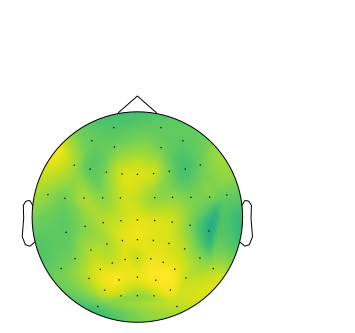

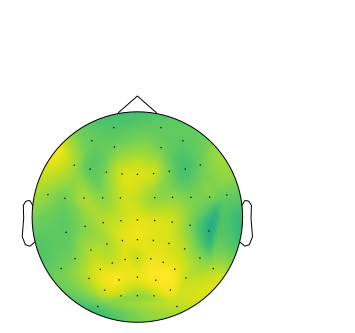

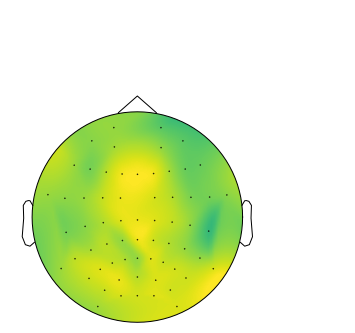

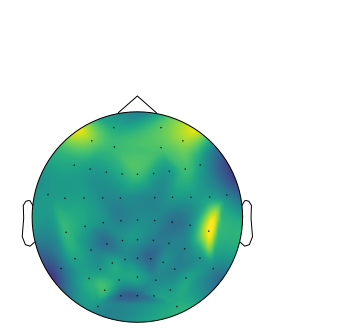

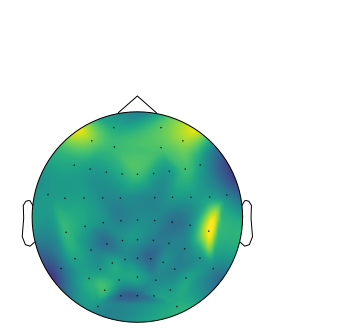

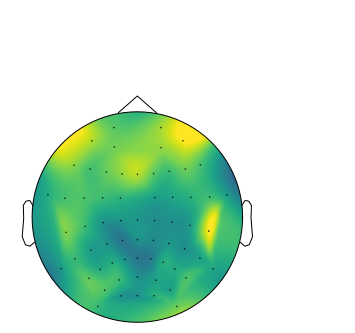

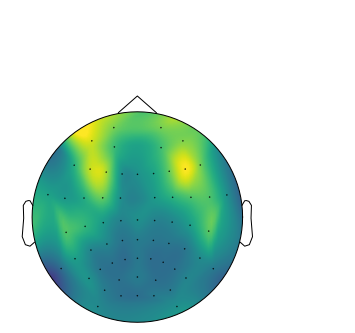

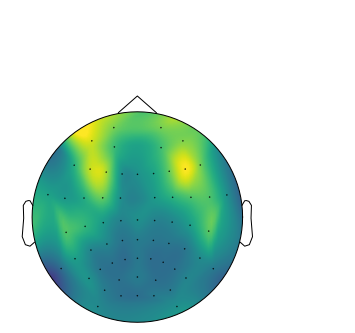

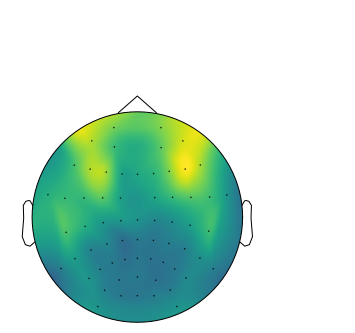

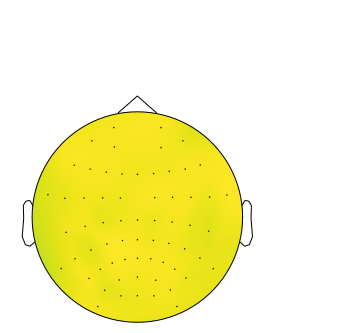

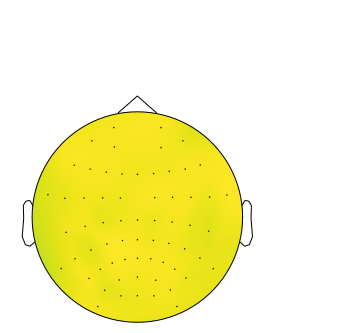

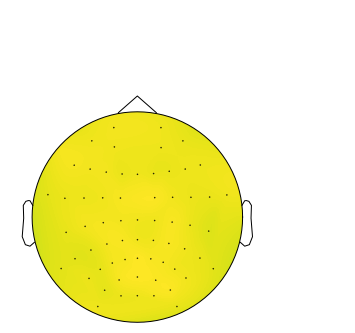

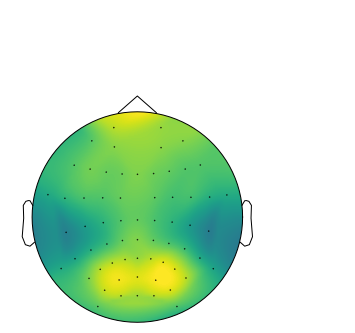

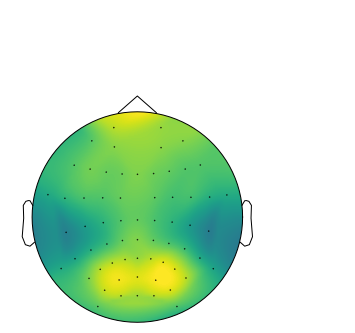

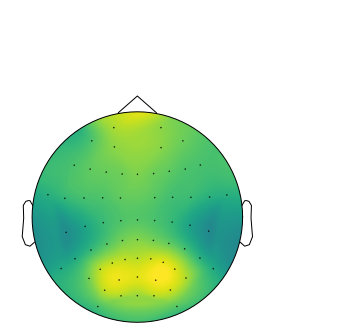

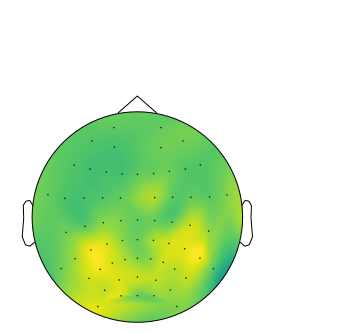

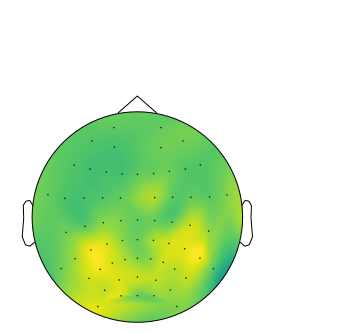

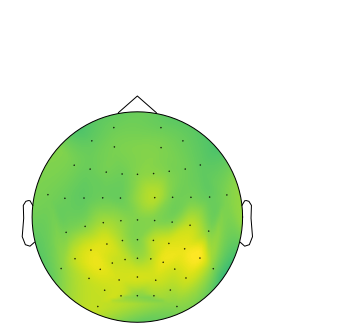

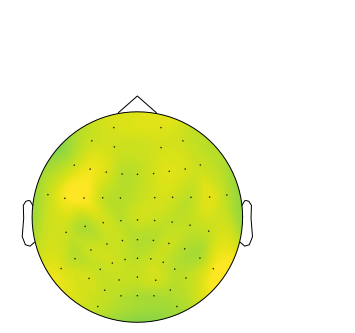

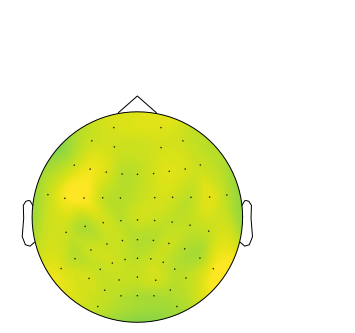

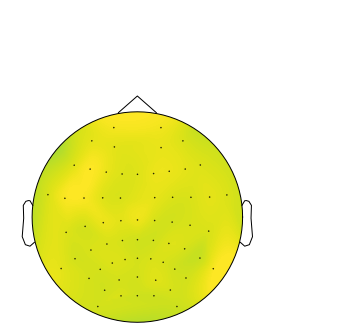

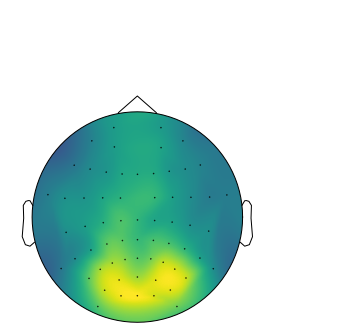

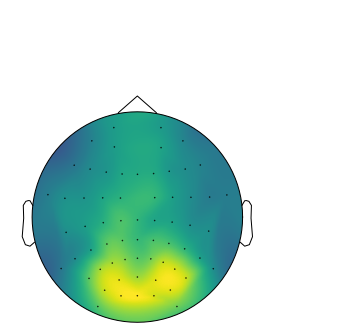

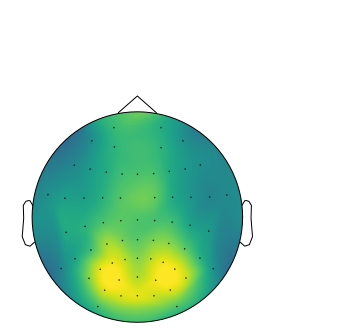

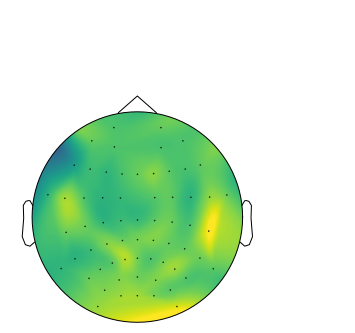

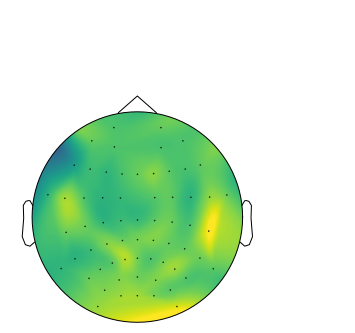

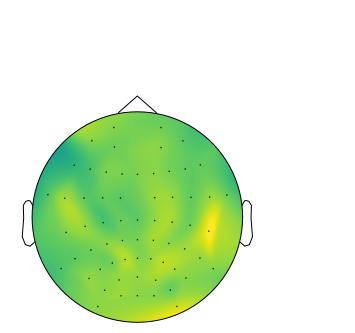

C:\Users\abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


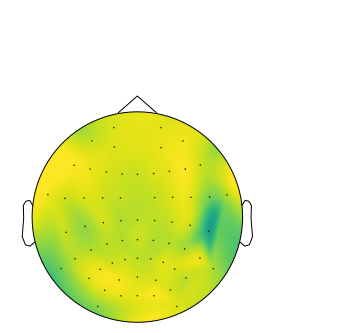

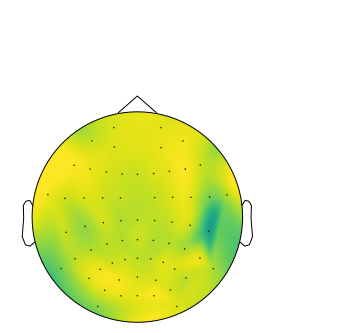

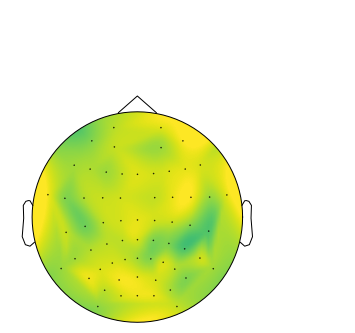

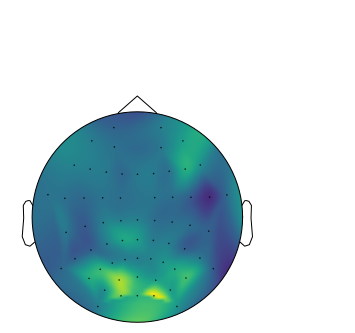

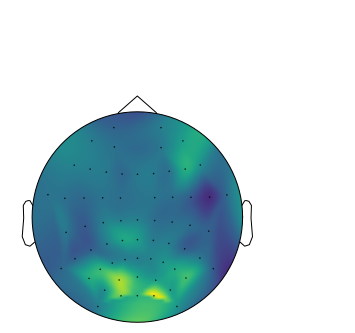

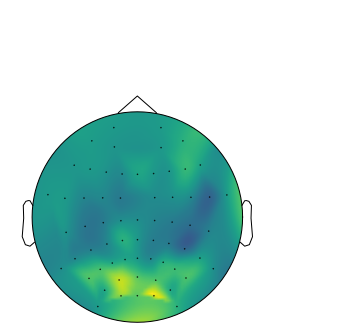

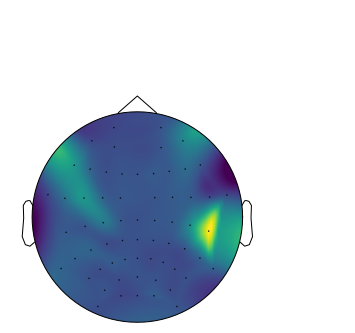

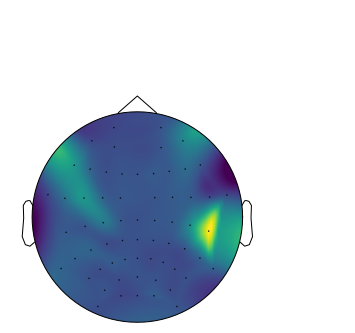

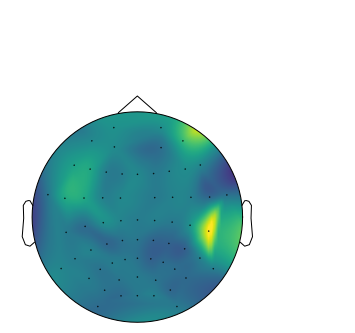

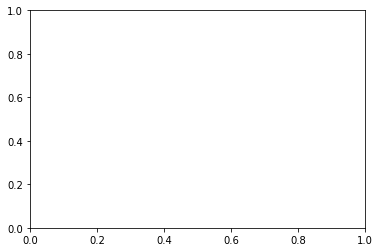

In [89]:
# Make topos, for each state, within and between datasets, for all features and bands
make_topos([PBA_trial_results, rtPB_trial_results])
make_topos([PBA_rest_results, rtPB_rest_results])

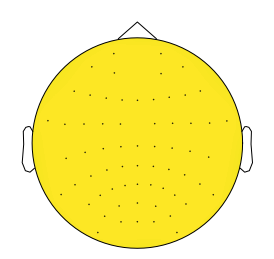

<Figure size 432x288 with 0 Axes>

In [60]:
dat = np.ones(shape=[64])
dat[2] = np.nan

plot_topo(dat, 'test')

In [97]:
q1 = im[0]
q2 = im[1]

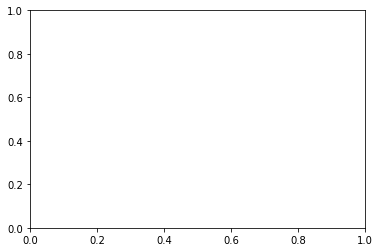

In [107]:
plt.gca()

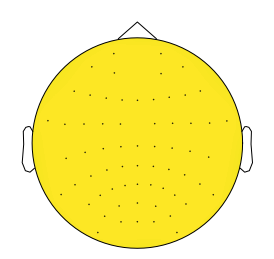

In [105]:
im = mne.viz.plot_topomap(np.ones(shape=[64]), eeg_dat.info, cmap=cm.viridis, contours=0, axes=plt.gca())

In [90]:
# Plot topography
# For sake of visualization, replace any NaN with the mean
temp_dat = ave_compl_data
inds = np.where(np.isnan(temp_dat))
temp_dat[inds] = np.nanmean(temp_dat)

mne.viz.plot_topomap(ave_compl_data, eeg_dat.info, cmap=cm.viridis, contours=0)
save_figure(SAVE_FIGS, 'new_test')

NameError: name 'ave_compl_data' is not defined

# SLOPE TOPOPLOTS
## Settings

In [17]:
# slope_feat_in 0:off-set 1:slope 
slope_feat_in = 1
# task
curr_task = "trial"

if (curr_task=="trial"):
    curr_datasets = [PBA_trial_slope_results, rtPB_trial_slope_results]
elif (curr_task=="rest"):
    curr_datasets = [PBA_rest_slope_results, rtPB_rest_slope_results]
else:
    print("The dataset you have specified does not exist")

In [18]:
across_datasets = []

for dataset in curr_datasets:
    slope_feat_set =  curr_datasets[0][:,:,:,slope_feat_in]
    slope_bloc_aver_set = np.nanmean(slope_feat_set, axis = 1)
    across_datasets.append(slope_bloc_aver_set)

compl_data = np.vstack((across_datasets[0], across_datasets[1]))
ave_compl_data = np.nanmean(compl_data, axis = 0)

In [19]:
ave_compl_data

array([0.5373638 , 0.45044231, 0.89157488, 0.67746804, 1.1798042 ,
       0.67189576, 0.95927361, 0.64726093, 1.07814676, 1.13087829,
       0.69722297, 0.50312801, 0.96137752, 1.22742988, 0.93113606,
       0.35837885, 1.0479408 , 1.00641934, 1.25268407, 1.22144681,
       1.04750011, 0.94659468, 1.04909558, 1.21752096, 1.33127288,
       1.20000546, 1.00175973, 0.89386347, 1.01090569, 1.04658521,
       0.94913781, 0.74643743, 0.57492583, 0.51055774, 0.470358  ,
       0.55914159, 0.48709936, 1.0602516 , 1.04083825, 0.54179566,
       1.26077696, 0.90289841, 0.81000043, 0.81016466, 0.86502018,
       1.26349161, 0.60568318, 1.15419269, 1.14822794, 0.69343687,
       0.70745056, 1.11053695, 1.29154199, 1.10395247, 0.69370722,
       1.12433293, 1.24654001, 1.28138468, 1.11755666, 0.99967118,
       1.23301501, 1.28247936, 1.150014  , 0.97245354])

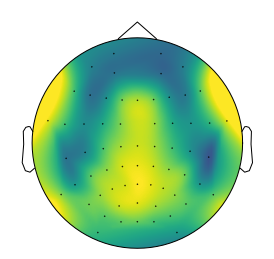

NameError: name 'save_figure' is not defined

In [20]:
# Plot topography
# For sake of visualization, replace any NaN with the mean
temp_dat = ave_compl_data
inds = np.where(np.isnan(temp_dat))
temp_dat[inds] = np.nanmean(temp_dat)

mne.viz.plot_topomap(ave_compl_data, eeg_dat.info, cmap=cm.viridis, contours=0)
save_figure(SAVE_FIGS, 'new_test')

NameError: name 'colors' is not defined

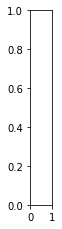

In [21]:
# Create a colorbar for the topography plots
fig = plt.figure(figsize=(2, 3))
ax1 = fig.add_axes([0.9, 0.25, 0.15, 0.9])

cmap = cm.viridis
norm = colors.Normalize(vmin=1.5, vmax=1.8)

cb1 = colorbar.ColorbarBase(plt.gca(), cmap=cmap,
                            norm=norm,
                            orientation='vertical')

#plt.savefig('colorbar.png', format='png', bbox_inches='tight', dpi=300)

In [22]:
fig = plt.figure(figsize=(1, 3))
cmap = cm.viridis
norm = mpl.colors.Normalize(vmin=group_bands[band][:,features[feature]].min(), vmax=group_bands[band][:,features[feature]].max())
cb = mpl.colorbar.ColorbarBase(plt.gca(), cmap=cmap, norm=norm, orientation='vertical')

NameError: name 'mpl' is not defined

<Figure size 72x216 with 0 Axes>

# Scatter plots


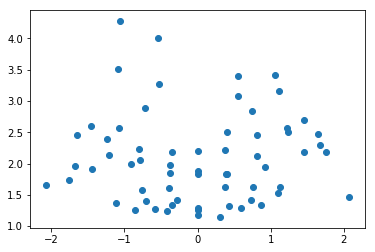

In [145]:
plt.scatter(pos[:, 0], ave_compl_data)
# left to right
save_figure(SAVE_FIGS, 'new_test')

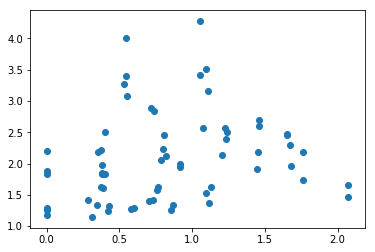

In [146]:
plt.scatter(abs(pos[:, 0]), ave_compl_data)
#medial to lateral
save_figure(SAVE_FIGS, 'new_test')

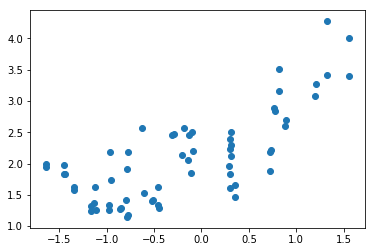

In [147]:
plt.scatter(pos[:, 1], ave_compl_data)
# posterior to anterior
save_figure(SAVE_FIGS, 'new_test')

In [70]:
pearsonr(ave_compl_data, pos[:, 1])

(-0.49140414843401453, 3.7353681931318474e-05)

# Task

In [ ]:
data = t_group_bands[band][:,features[feature]]
masked_arr = mask_nan_array(data)
plot = mne.viz.plot_topomap(t_group_bands[band][:,features[feature]][masked_arr], pos[masked_arr], cmap=cm.viridis, contours=0)

# Subtraction of Group Level Plots

In [ ]:
data =  group_bands[band][:,features[feature]] - t_group_bands[band][:,features[feature]]
masked_arr = mask_nan_array(data)
plot = mne.viz.plot_topomap(t_group_bands[band][:,features[feature]][masked_arr], pos[masked_arr], cmap=cm.viridis, contours=0)

In [ ]:
np.mean(data)
# Alpha speeds up as you performa a task
# Spatial shifts and  task related shift to peak alpha frequency

In [ ]:
# Make a table with band of interest as columns 

In [ ]:
fig = plt.figure(figsize=(1, 3))
cmap = cm.viridis
norm = mpl.colors.Normalize(vmin=group_bands[band][:,features[feature]].min(), vmax=group_bands[band][:,features[feature]].max())
cb = mpl.colorbar.ColorbarBase(plt.gca(), cmap=cmap, norm=norm, orientation='vertical')

# SPATIAL CORRELATIONS: Position & Band Features

In [ ]:
# Correlations & Plots
# Average feature value at each channel
# For posterior -> anterior
# Check: left -> right
# Check: Medial -> lateral

In [ ]:
dat = group_bands[band][:,features[feature]]

In [ ]:
dat

In [ ]:
# Correlation Matrix
#  Each matrix: rows are bands, columns are FOOOF features
#    Each value is the corr value (r) between the data of that Band & Feature to a spatial dimension
#    There is a corr-matrix for each spatial dim
# Bonus: plot the matrix in colours.

In [ ]:
index = group_bands.keys()
columns = features.keys()
df = pd.DataFrame(index=index, columns=columns)

for band in group_bands:
    for feature in features:
        data = group_bands[band][:,features[feature]]
        masked_arr = mask_nan_array(data)
        # pos => pos[masked_arr, 0] --> left to right
        # pos => abs(pos[masked_arr, 0]) --> medial to lateral 
        # pos => pos[masked_arr, 1] --> posterior to anterior
        corr_val = pearsonr(pos[masked_arr, 1], data[masked_arr])[0]
        df.loc[band, feature] = corr_val
    


In [ ]:
df
# medial to lateral

In [ ]:
df
# posterior to anterior

## Spatial Correlations: Per Subject level

Run the same correlations as above (ex. CF per channel), per subject
Collect the distributions of R values

In [ ]:
# Settings
band = 'alpha'
feat = 'CFS'

In [ ]:
rs = []; ps = []
a_cf = subject_bands[band][:,features[feat]]
for si in range(13):
    masked_arr = mask_nan_array(a_cf[:,si])
    # pos => pos[masked_arr, 0] --> left to right
    # pos => abs(pos[masked_arr, 0]) --> medial to lateral 
    # pos => pos[masked_arr, 1] --> posterior to anterior
    rs.append(pearsonr(pos[masked_arr, 1], a_cf[:,si][masked_arr])[0])
    #print(pearsonr(pos[masked_arr, 0], a_cf[masked_arr])[0])
    #ps[si]= pearsonr(pos[masked_arr, 0], data[masked_arr])[1]

In [ ]:
rs

In [ ]:
plt.boxplot(rs);

# Spatial Correlations Between Bands

In [ ]:
feature = 'CFS'

In [ ]:
index = group_bands.keys()
d_corrm = pd.DataFrame(index=index)
#Dataframe for correlaton matrix
for band in group_bands:
    data = group_bands[band][:,features[feature]]
    masked_arr = mask_nan_array(data)
    # pos => pos[masked_arr, 0] --> left to right
    # pos => abs(pos[masked_arr, 0]) --> medial to lateral 
    # pos => pos[masked_arr, 1] --> posterior to anterior
    

In [ ]:
index = group_bands.keys()
d_corrm = pd.DataFrame(index=index, columns=index, dtype = float)
#Dataframe for correlaton matrix
for band in group_bands:
    data1 = group_bands[band][:,features[feature]]
    for band2 in group_bands:
        data2 = group_bands[band2][:,features[feature]]
        masked_arr1=mask_nan_array(data1)
        masked_arr2=mask_nan_array(data2)
        corr_val = pearsonr(data1, data2)[0]
        d_corrm.loc[band, band2] = corr_val


In [ ]:
d_corrm

In [ ]:
d_corrm.values

In [ ]:
plt.imshow(d_corrm)